In [1]:
import utils 
import transformer 
import bar_distribution
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import random
import prior 
matplotlib.use('TkAgg')
%matplotlib inline
import main
import importlib
device = torch.device("cuda")
importlib.reload(utils)
importlib.reload(transformer)
importlib.reload(bar_distribution)
importlib.reload(main)
importlib.reload(prior)
import random

In [2]:
print(f"Using device: {torch.cuda.get_device_name(torch.cuda.current_device())}")
device = torch.device("cuda")
d_model, nhead, nhid, nlayers = 256, 4, 512, 4
seq_len = 50
num_epochs = 100
lr = 0.001
num_outputs = 3
batch_size = 500
in_features = 2
noise = False
warm_up_epochs = 5
model = transformer.Transformer(d_model, nhead, nhid, nlayers,in_features=in_features, buckets_size=num_outputs).to(device)
print(f"total params:{sum(p.numel() for p in model.parameters())}")
#criterion = bar_distribution.FullSupportBarDistribution(bar_distribution.get_bucket_limits(num_outputs=num_outputs,ys=y))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = utils.get_cosine_schedule_with_warmup(optimizer, warm_up_epochs, num_epochs)
model.criterion = criterion

Using device: Quadro P1000


C:\Users\prajb\anaconda3new\envs\cuda_test\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


total params:2112778


In [3]:
%matplotlib inline
trains= main.train(model, criterion, num_epochs, optimizer, scheduler, batch_size, seq_len, in_features)

| epoch   0 | lr 0.0002 || loss 2.417
| epoch  10 | lr 0.0009901899829374047 || loss 1.681
| epoch  20 | lr 0.000931628240478787 || loss 1.510
| epoch  30 | lr 0.0008262928807620843 || loss 1.271
| epoch  40 | lr 0.0006855986244591103 || loss 1.241
| epoch  50 | lr 0.0005247918773366112 || loss 1.036
| epoch  60 | lr 0.00036129854561907783 || loss 0.962
| epoch  70 | lr 0.0002128356686585282 || loss 0.962
| epoch  80 | lr 9.549150281252633e-05 || loss 0.900
| epoch  90 | lr 2.198210923282118e-05 || loss 0.835


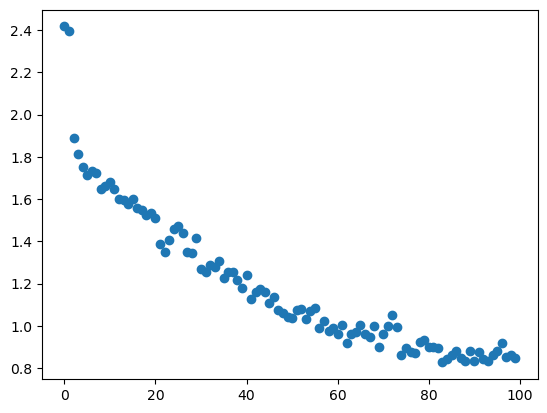

In [4]:
%matplotlib inline
plt.scatter(np.arange(num_epochs), trains, label="training loss")
plt.show()

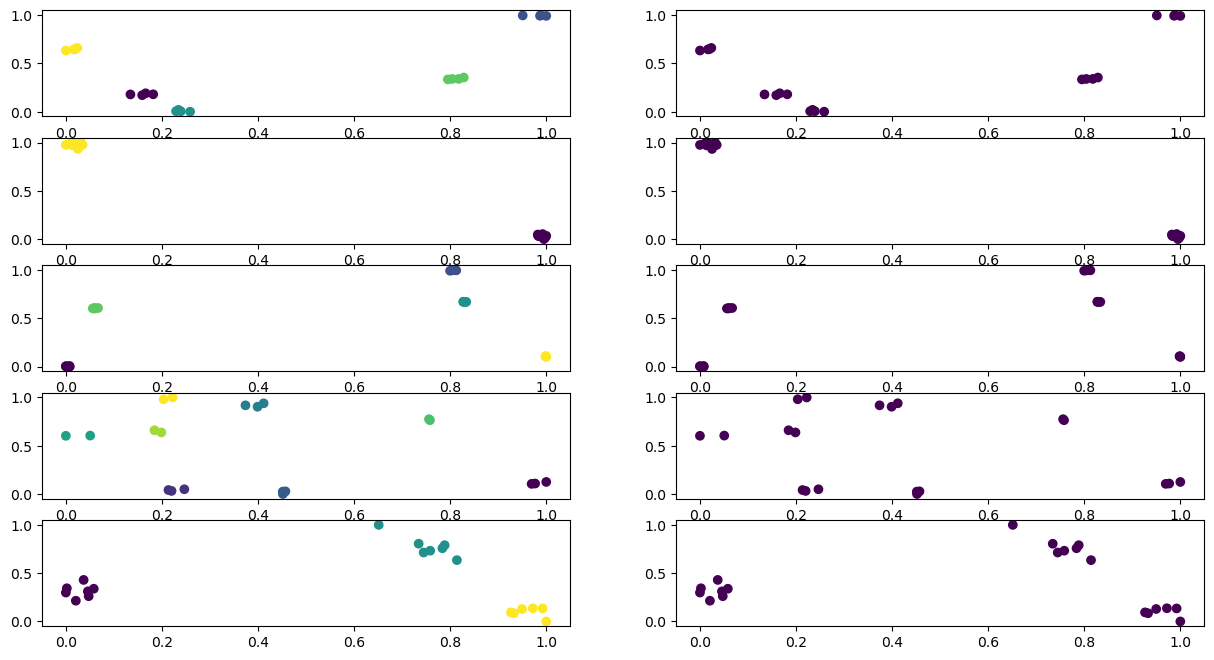

In [12]:
%matplotlib inline
temp_batch_size = 5
train_X, train_Y, y_target= prior.sample_clusters(batch_size=temp_batch_size,seq_len=20)
num_training_points = 20
model.eval()
# # Set up grid for subplots
fig, axes = plt.subplots(5, 2, figsize=(15, 8)) 
axes = axes.flatten() 
for batch_index in range(temp_batch_size):
    axes[2 * batch_index].scatter(train_X[:,batch_index,0].cpu().numpy() , train_X[:, batch_index, 1].cpu().numpy() , c=train_Y[:,batch_index].cpu().numpy())

    train_x = train_X[:, batch_index]
    train_y = train_Y[:, batch_index]
    # test_x = train_X[:, batch_index]
    logits = model(train_x, train_y, train_x, 0, has_mask=False)
    predictions = torch.argmax(logits, dim=1)
    axes[2 * batch_index +1].scatter(train_X[:,batch_index,0].cpu().numpy() , train_X[:, batch_index, 1].cpu().numpy() , c=predictions.cpu().numpy())
    
plt.show()

